In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from tqdm import tqdm
import pandas as pd
from matplotlib.patches import Rectangle

import xarray as xr

import netCDF4
from netCDF4 import Dataset

import gsw as gsw
import os


plt.close('all')

## Functions:


In [2]:
def get_coast():
    f = open('CO.txt', 'r') # 'r' = read
    k=int(0)
    BADVAL=float('NaN')

    # check file size first
    for line in f:
        k+=1
    
    print('number of coastline points is ' + str(k))
    
    # declare arrays to store lat lon vetctor data
    la=np.zeros(k)
    lo=np.zeros(k)
    k=int(0)
    f.close()

    f = open('CO.txt', 'r')
    for line in f:
        if (line[0]=='*'):
            la[k]=BADVAL
            lo[k]=BADVAL
        else:
            lo[k]=float(line[0:13])
            la[k]=float(line[14:27])
        k+=1
    f.close()

    return (lo,la)

In [3]:
def get_argo_float(path):
    df_out = pd.DataFrame()
    ds = xr.open_dataset(path)
    df = ds.to_dataframe()

    df_out["pres"] = np.array(df['PRES'][0,:])  #nur das erste weil wir wollen nur wenn das gerät nach unten geht und nicht wieder wenn es ein profil bei hoochgehen erstellt
    df_out["temp"] = np.array(df['TEMP'][0,:])
    df_out["sal"] = np.array(df['PSAL'][0,:])

    df_out["float_id"] = int(df["PLATFORM_NUMBER"][0,0,0,0][0])

    df_out["lat"] = np.array(df['LATITUDE'][0,:])
    df_out["lon"] = np.array(df['LONGITUDE'][0,:])
    df_out["time_juld"] = np.array(df['JULD'][0,:])

    df_out["SA"] = gsw.conversions.SA_from_SP(df_out["sal"],df_out["pres"] ,df_out["lon"][1],df_out["lat"][1])
    df_out["CT"] = gsw.conversions.CT_from_t(df_out["SA"],df_out["temp"],df_out["pres"])

    df_out["sigma0"] = gsw.density.sigma0(df_out["SA"],df_out["CT"])

    
    
    return df_out


In [4]:
def plot_graphs(df):
    plt.figure(figsize=(10, 6),dpi = 300)
    fig,axs = plt.subplots(1, 3, figsize=(8, 6))

    grad = np.gradient(df["temp"].to_numpy(),df["depth"].to_numpy())
    tc_dep = df["depth"].to_numpy()[np.argmin(grad)]

    axs[0].hlines(-tc_dep,min(df["sal"]),max(df["sal"]),alpha = 0.5)
    axs[0].scatter(df["sal"], -df["pres"], s=3, color='purple')
    axs[0].set_xlabel('salinity')
    axs[0].set_ylabel('pressure')
    axs[0].grid()
    axs[0].set_title("Salinity")

    axs[1].hlines(-tc_dep,min(df["temp"]),max(df["temp"]),alpha = 0.5)
    axs[1].scatter(df["temp"],-df["pres"], s=3, color = 'orange')
    axs[1].tick_params('y', labelleft=False)
    axs[1].set_xlabel('temperature')
    axs[1].grid()
    axs[1].set_title("Temperature")

    axs[2].hlines(-tc_dep,min(df["sigma0"]),max(df["sigma0"]),alpha = 0.5)
    axs[2].scatter(df["sigma0"],-df["pres"], s=3, color='green')
    axs[2].tick_params('y', labelleft=False)
    axs[2].set_xlabel('density')
    axs[2].grid()
    axs[2].set_title("Density")

    axs[0].set_ylim([-2000, 0])
    axs[1].set_ylim([-2000, 0])
    axs[2].set_ylim([-2000, 0])
    title = ('profiles at '
             + 'lat: ' + str(df["lat"].iloc[0]) 
             + ', lon: '+  str(df["lon"].iloc[0]) 
             +  ' on ' + str(df["time_juld"].iloc[0])[:10] 
             + "\n"
             + "Thermocline at: "
             + f"{tc_dep}m"
             )
    plt.suptitle(title)

    

In [5]:
def get_tc_df(df):
    lats =  []
    lons = []
    tc_depths = []
    dates = []
    for date in df["time_juld"].unique():
        df_loop = df.loc[df["time_juld"] == date]
        dates.append(date)
        lats.append(df_loop["lat"].unique()[0])
        lons.append(df_loop["lon"].unique()[0])
        grad = np.gradient(df_loop["temp"].to_numpy(),df_loop["depth"].to_numpy())
        tc_depth = df_loop["depth"].to_numpy()[np.argmin(grad)] 
        if tc_depth < 300:
            tc_depths.append(tc_depth)
        else:
            tc_depths.append(np.nan)

    df_out = pd.DataFrame()
    df_out["lon"] = lons
    df_out["lat"] = lats
    df_out["tc_depth"] = tc_depths
    df_out["date"] = dates
    return df_out

In [6]:
def remove_consecutive_duplicates(arr):
    if len(arr) == 0:
        return []
    
    result = [arr[0]]  # Start with the first element
    
    for i in range(1, len(arr)):
        if arr[i] != arr[i-1]:
            result.append(arr[i])
    
    return result

## Load Data:

In [7]:
name =   'aoml'   # 'bodc'
number =  '4902345' #
time =    'D4902345_005' #east: 'D6902768_180', 'D3901236_195' 'D1902208_005' west: 'D4902120_020', 'D4902114_040', 'D4902928_010'


full_path = (name +'/' + number + '/profiles/'+ time + '.nc')
full_path2 = (name +'/' + number + '/profiles/')

df_1 = get_argo_float(full_path)

In [8]:
if 'df_aoml' not in locals():
    df_aoml = pd.DataFrame()
    for file in sorted(os.listdir(full_path2))[0:200]:
        df = get_argo_float(full_path2+file)
        df_aoml = pd.concat([df_aoml,df[0:df["pres"].idxmax()]])
    df_aoml = df_aoml.drop_duplicates(ignore_index=True)
    df_aoml["x_prime"] = (np.sin(df_aoml["lat"]/57.29578))**2
    df_aoml["grav"] = 9.780318*(1.0+(5.2788*10**(-3)+2.36*10**(-5)*df_aoml["x_prime"])*df_aoml["x_prime"]) + 1.092*10**(-6)*df_aoml["pres"]  #GRAVITY VARIATION WITH LAT: ANON (1970) BULLETIN GEODESIQUE
    df_aoml["depth_before"] = (((-1.82E-15*df_aoml["pres"]+2.279*10**(-10))*df_aoml["pres"]-2.2512*10**(-5))*df_aoml["pres"]+9.72659)*df_aoml["pres"] #DEPTH BEFORE GRAVITY CORRECTION
    df_aoml["depth"] = df_aoml["depth_before"]/df_aoml["grav"]

# https://www.nodc.noaa.gov/archive/arc0022/0001155/1.1/data/0-data/docs/common/depthCTD-calculated.htm

In [9]:
if 'df_bodc' not in locals():
    df_bodc = pd.DataFrame()
    full_path3 = "bodc/6901143/profiles/"
    for file in sorted(os.listdir(full_path3))[0:124]:
        df = get_argo_float(full_path3+file)
        df_bodc = pd.concat([df_bodc,df[0:df["pres"].idxmax()]])
    df_bodc = df_bodc.drop_duplicates(ignore_index=True)
    df_bodc["x_prime"] = (np.sin(df_bodc["lat"]/57.29578))**2
    df_bodc["grav"] = 9.780318*(1.0+(5.2788*10**(-3)+2.36*10**(-5)*df_bodc["x_prime"])*df_bodc["x_prime"]) + 1.092*10**(-6)*df_bodc["pres"]  #GRAVITY VARIATION WITH LAT: ANON (1970) BULLETIN GEODESIQUE
    df_bodc["depth_before"] = (((-1.82E-15*df_bodc["pres"]+2.279*10**(-10))*df_bodc["pres"]-2.2512*10**(-5))*df_bodc["pres"]+9.72659)*df_bodc["pres"] #DEPTH BEFORE GRAVITY CORRECTION
    df_bodc["depth"] = df_bodc["depth_before"]/df_bodc["grav"]

# https://www.nodc.noaa.gov/archive/arc0022/0001155/1.1/data/0-data/docs/common/depthCTD-calculated.htm

In [10]:
len(df_bodc["lat"].unique())

121

In [11]:
df_bodc

,pres,temp,sal,float_id,lat,lon,time_juld,SA,CT,sigma0,x_prime,grav,depth_before,depth
0,24.000000,23.745001,36.733002,6901143,32.0600,-14.6890,2012-10-15 05:55:14.999996928,36.906458,23.675154,25.033219,0.281756,9.794909,233.425201,23.831278
1,30.600000,23.743999,36.731998,6901143,32.0600,-14.6890,2012-10-15 05:55:14.999996928,36.905435,23.672802,25.033157,0.281756,9.794916,297.612579,30.384392
2,35.099998,23.712999,36.723999,6901143,32.0600,-14.6890,2012-10-15 05:55:14.999996928,36.897400,23.641168,25.036574,0.281756,9.794921,341.375580,34.852305
3,40.400002,23.579000,36.703999,6901143,32.0600,-14.6890,2012-10-15 05:55:14.999996928,36.877308,23.506880,25.061409,0.281756,9.794927,392.917542,40.114392
4,50.599998,20.941000,36.398998,6901143,32.0600,-14.6890,2012-10-15 05:55:14.999996928,36.570873,20.879462,25.581103,0.281756,9.794938,492.107819,50.241034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6536,1500.099976,6.750000,35.444000,6901143,34.2492,-18.2553,2019-06-21 08:21:03.999997184,35.614051,6.583751,27.827364,0.316736,9.798332,14540.959961,1484.024036
6537,1599.699951,6.208000,35.376999,6901143,34.2492,-18.2553,2019-06-21 08:21:03.999997184,35.546891,6.038762,27.847130,0.316736,9.798441,15502.937500,1582.184158
6538,1700.099976,5.769000,35.320999,6901143,34.2492,-18.2553,2019-06-21 08:21:03.999997184,35.490777,5.595713,27.859395,0.316736,9.798550,16472.212891,1681.086741
6539,1800.400024,5.343000,35.259998,6901143,34.2492,-18.2553,2019-06-21 08:21:03.999997184,35.429669,5.166035,27.863758,0.316736,9.798660,17440.091797,1779.844612


In [12]:
df_bodc_tc = get_tc_df(df_bodc)
df_aoml_tc = get_tc_df(df_aoml)

## Plotting and stuff:

number of coastline points is 61632


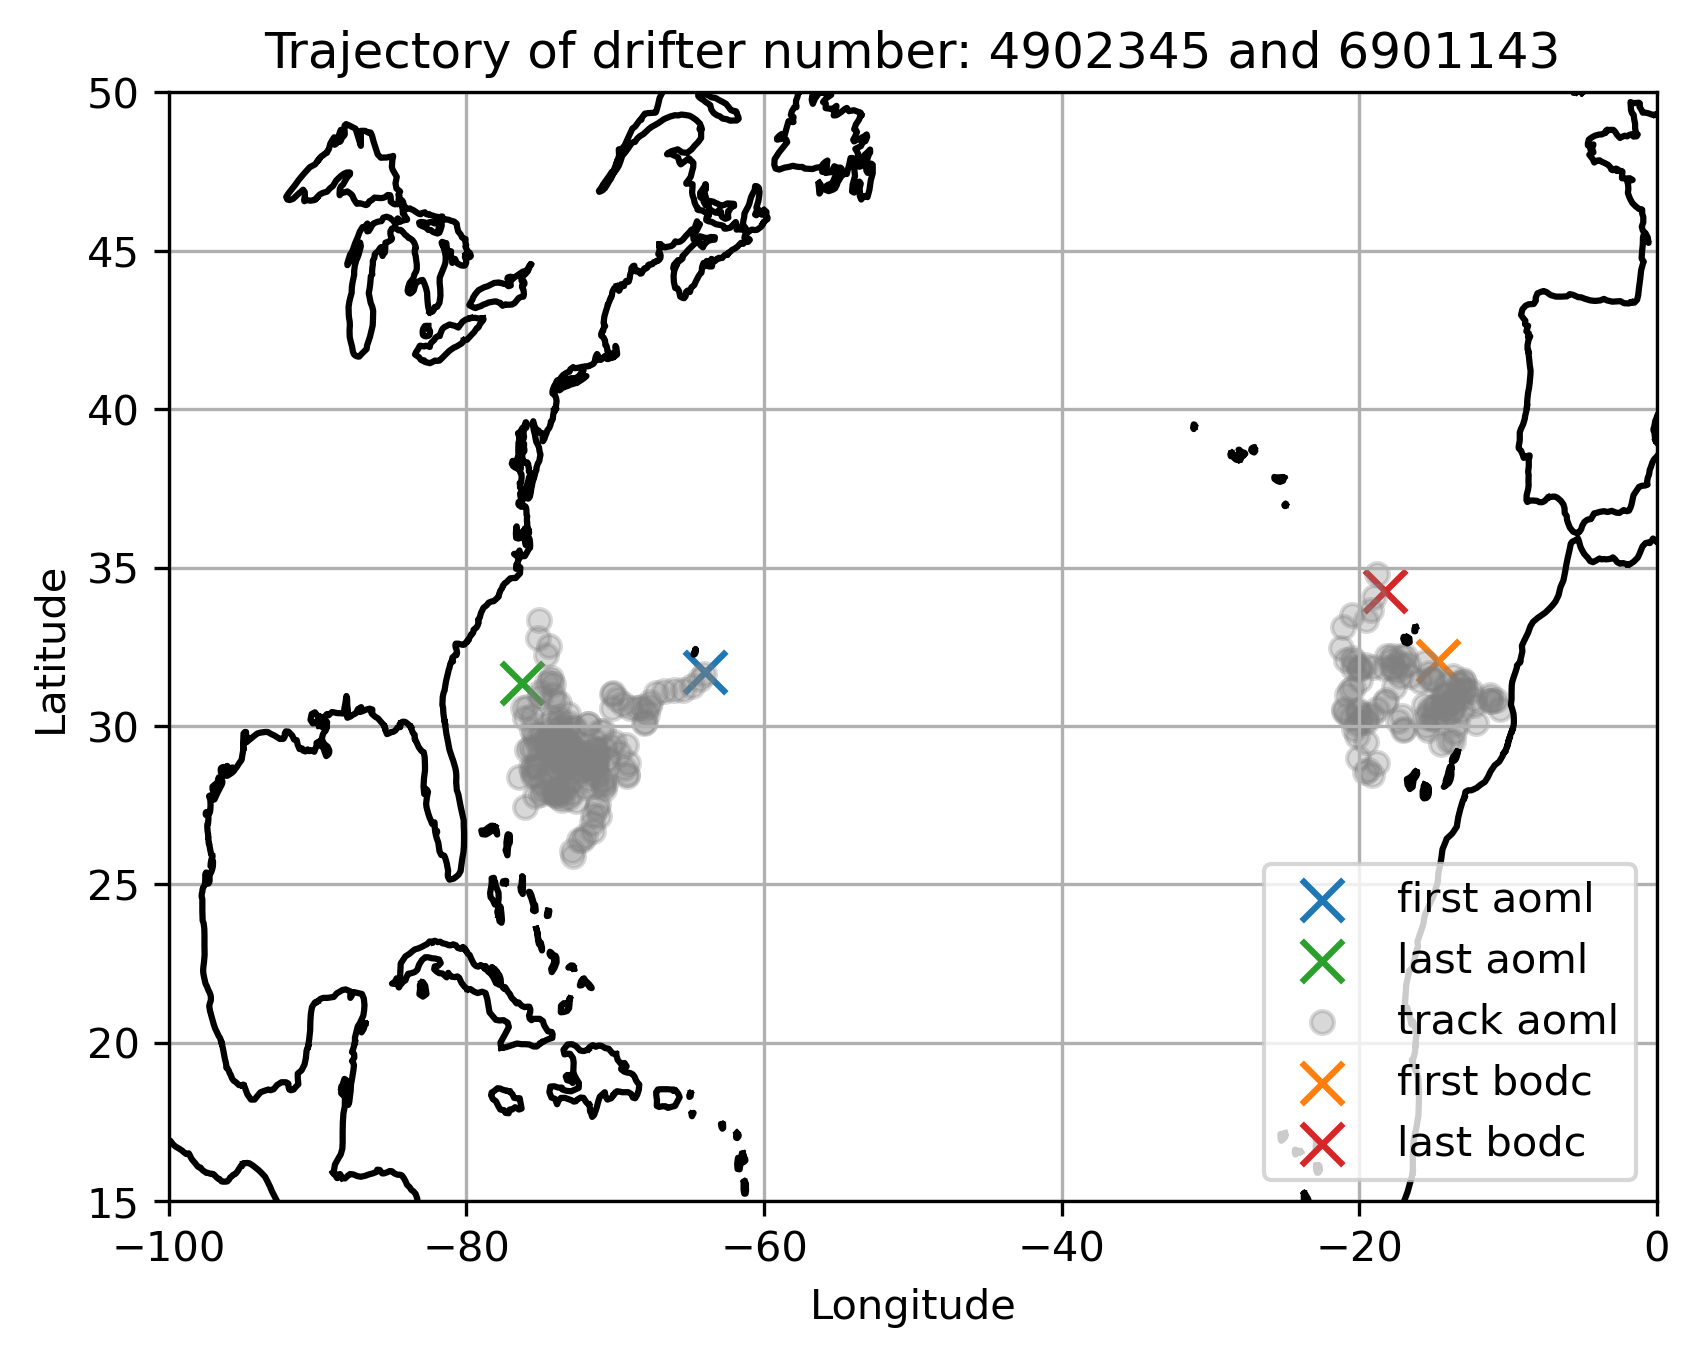

In [13]:
plt.figure(dpi = 300)

lo,la = get_coast()

lons = remove_consecutive_duplicates(df_aoml["lon"].to_numpy())
lats = remove_consecutive_duplicates(df_aoml["lat"].to_numpy())

plt.scatter(lons[0], lats[0], s=100, marker='x', color='tab:blue', label='first aoml')
plt.scatter(lons[-1], lats[-1], s=100, marker='x', color='tab:green', label='last aoml')
plt.scatter(lons[1:-2], lats[1:-2], s=30, alpha=0.3, color= 'grey',  label="track aoml")

lons = remove_consecutive_duplicates(df_bodc["lon"].to_numpy())
lats = remove_consecutive_duplicates(df_bodc["lat"].to_numpy())

plt.scatter(lons[0], lats[0], s=100, marker='x', color='tab:orange', label='first bodc')
plt.scatter(lons[-1], lats[-1], s=100, marker='x', color='tab:red', label='last bodc')
plt.scatter(lons[1:-2], lats[1:-2], s=30, alpha=0.3, color= 'grey')

plt.plot(lo, la, color='black')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Trajectory of drifter number: {number} and 6901143')
plt.ylim(15,50)
plt.xlim(-100,0)
plt.grid(True)
plt.legend(loc = "lower right")
plt.show()

<Figure size 3000x1800 with 0 Axes>

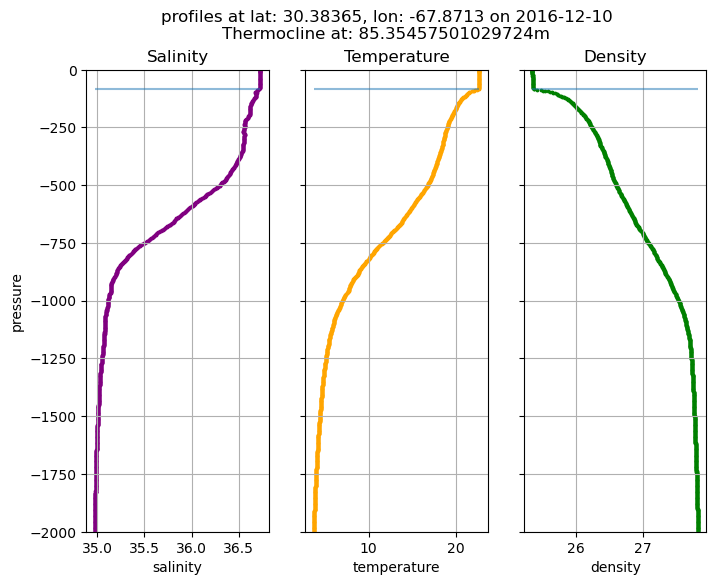

In [28]:
plot_graphs(df_aoml.loc[df_aoml["time_juld"] == df_aoml["time_juld"].unique()[10]])

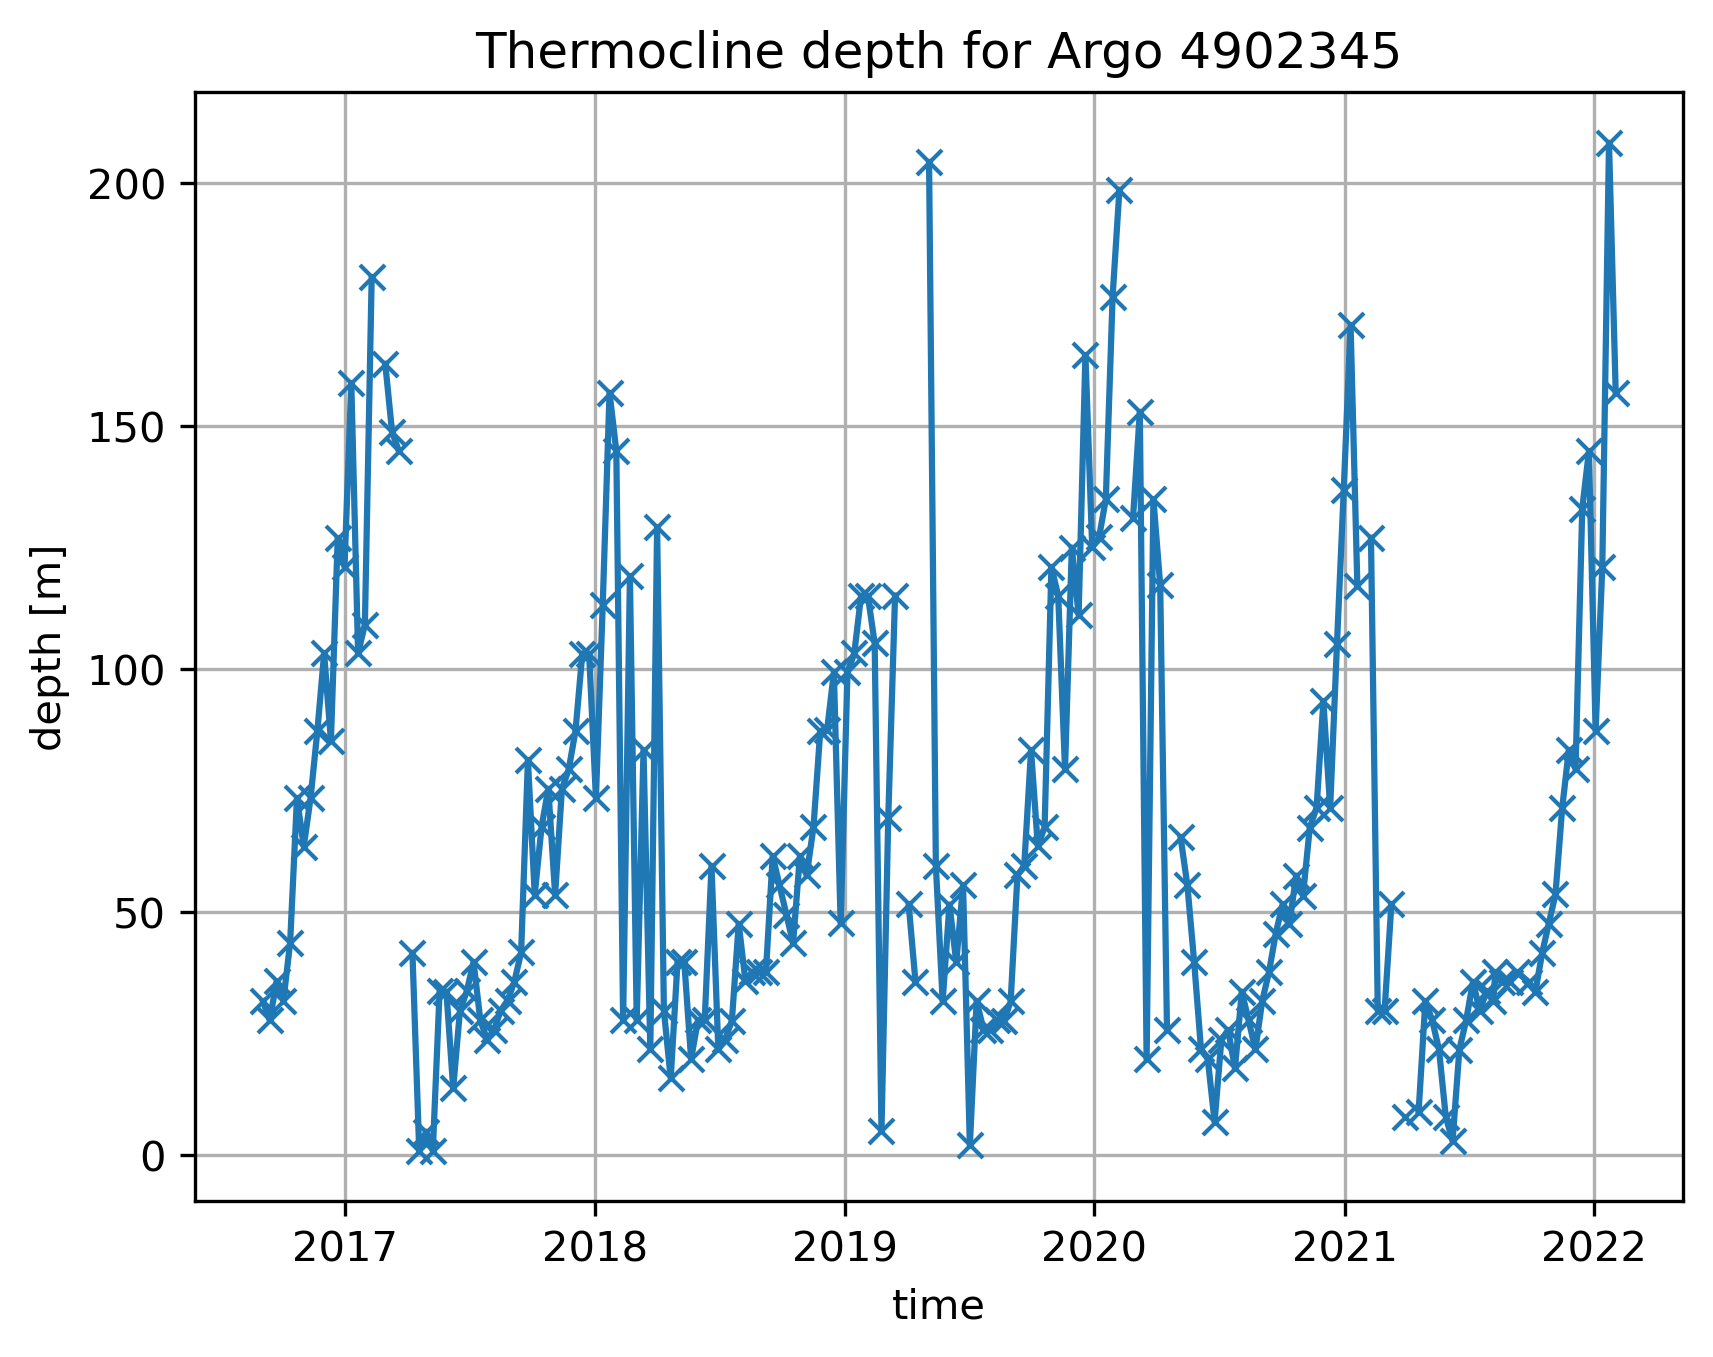

In [24]:
plt.figure(dpi = 300)
plt.plot(df_aoml_tc["date"],df_aoml_tc["tc_depth"],marker = "x")
plt.title(f"Thermocline depth for Argo {4902345}")
plt.ylabel("depth [m]")
plt.xlabel("time")
plt.grid()

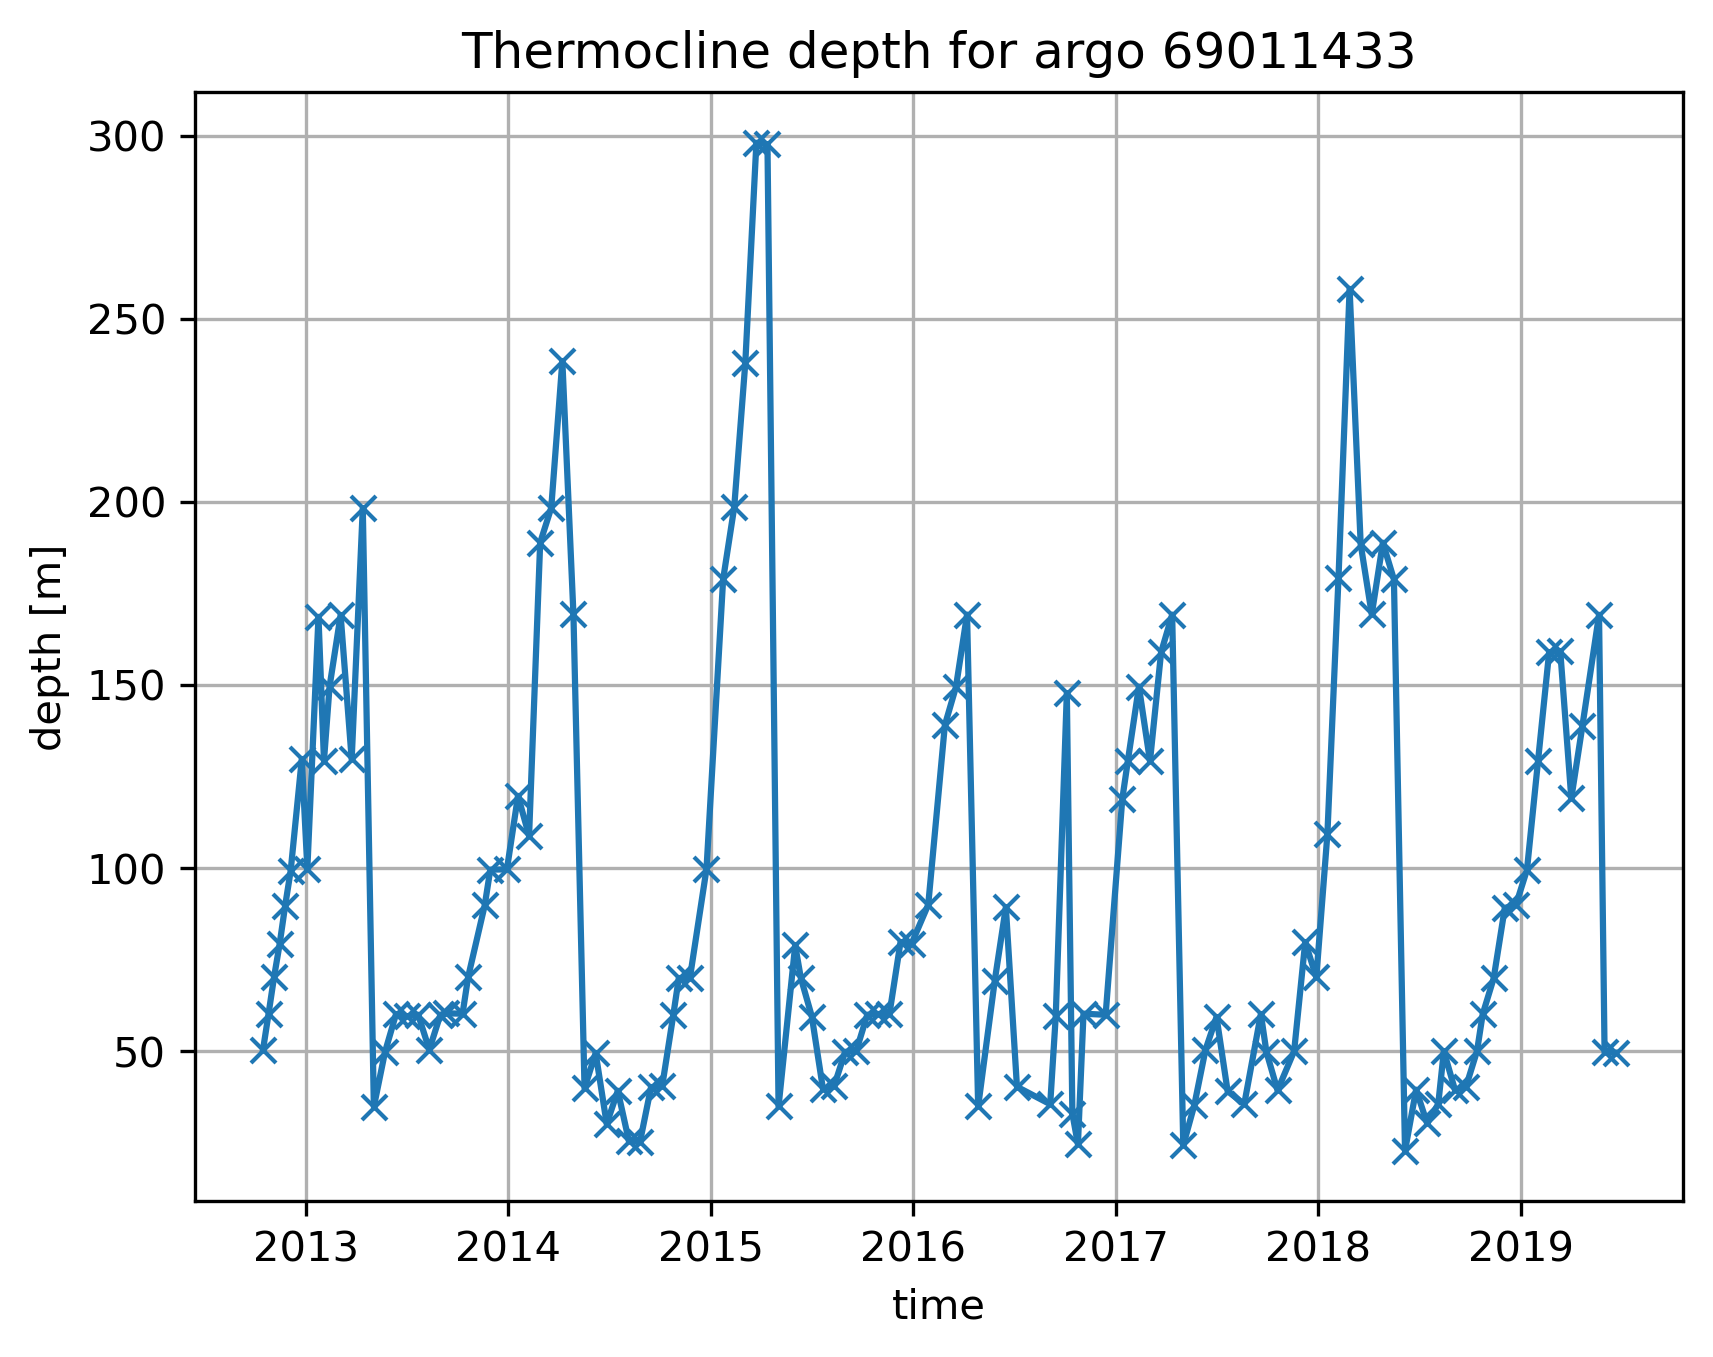

In [21]:
plt.figure(dpi = 300)
plt.plot(df_bodc_tc["date"],df_bodc_tc["tc_depth"],marker = "x")
plt.title(f"Thermocline depth for Argo {6901143}")
plt.ylabel("depth [m]")
plt.xlabel("time")
plt.grid()

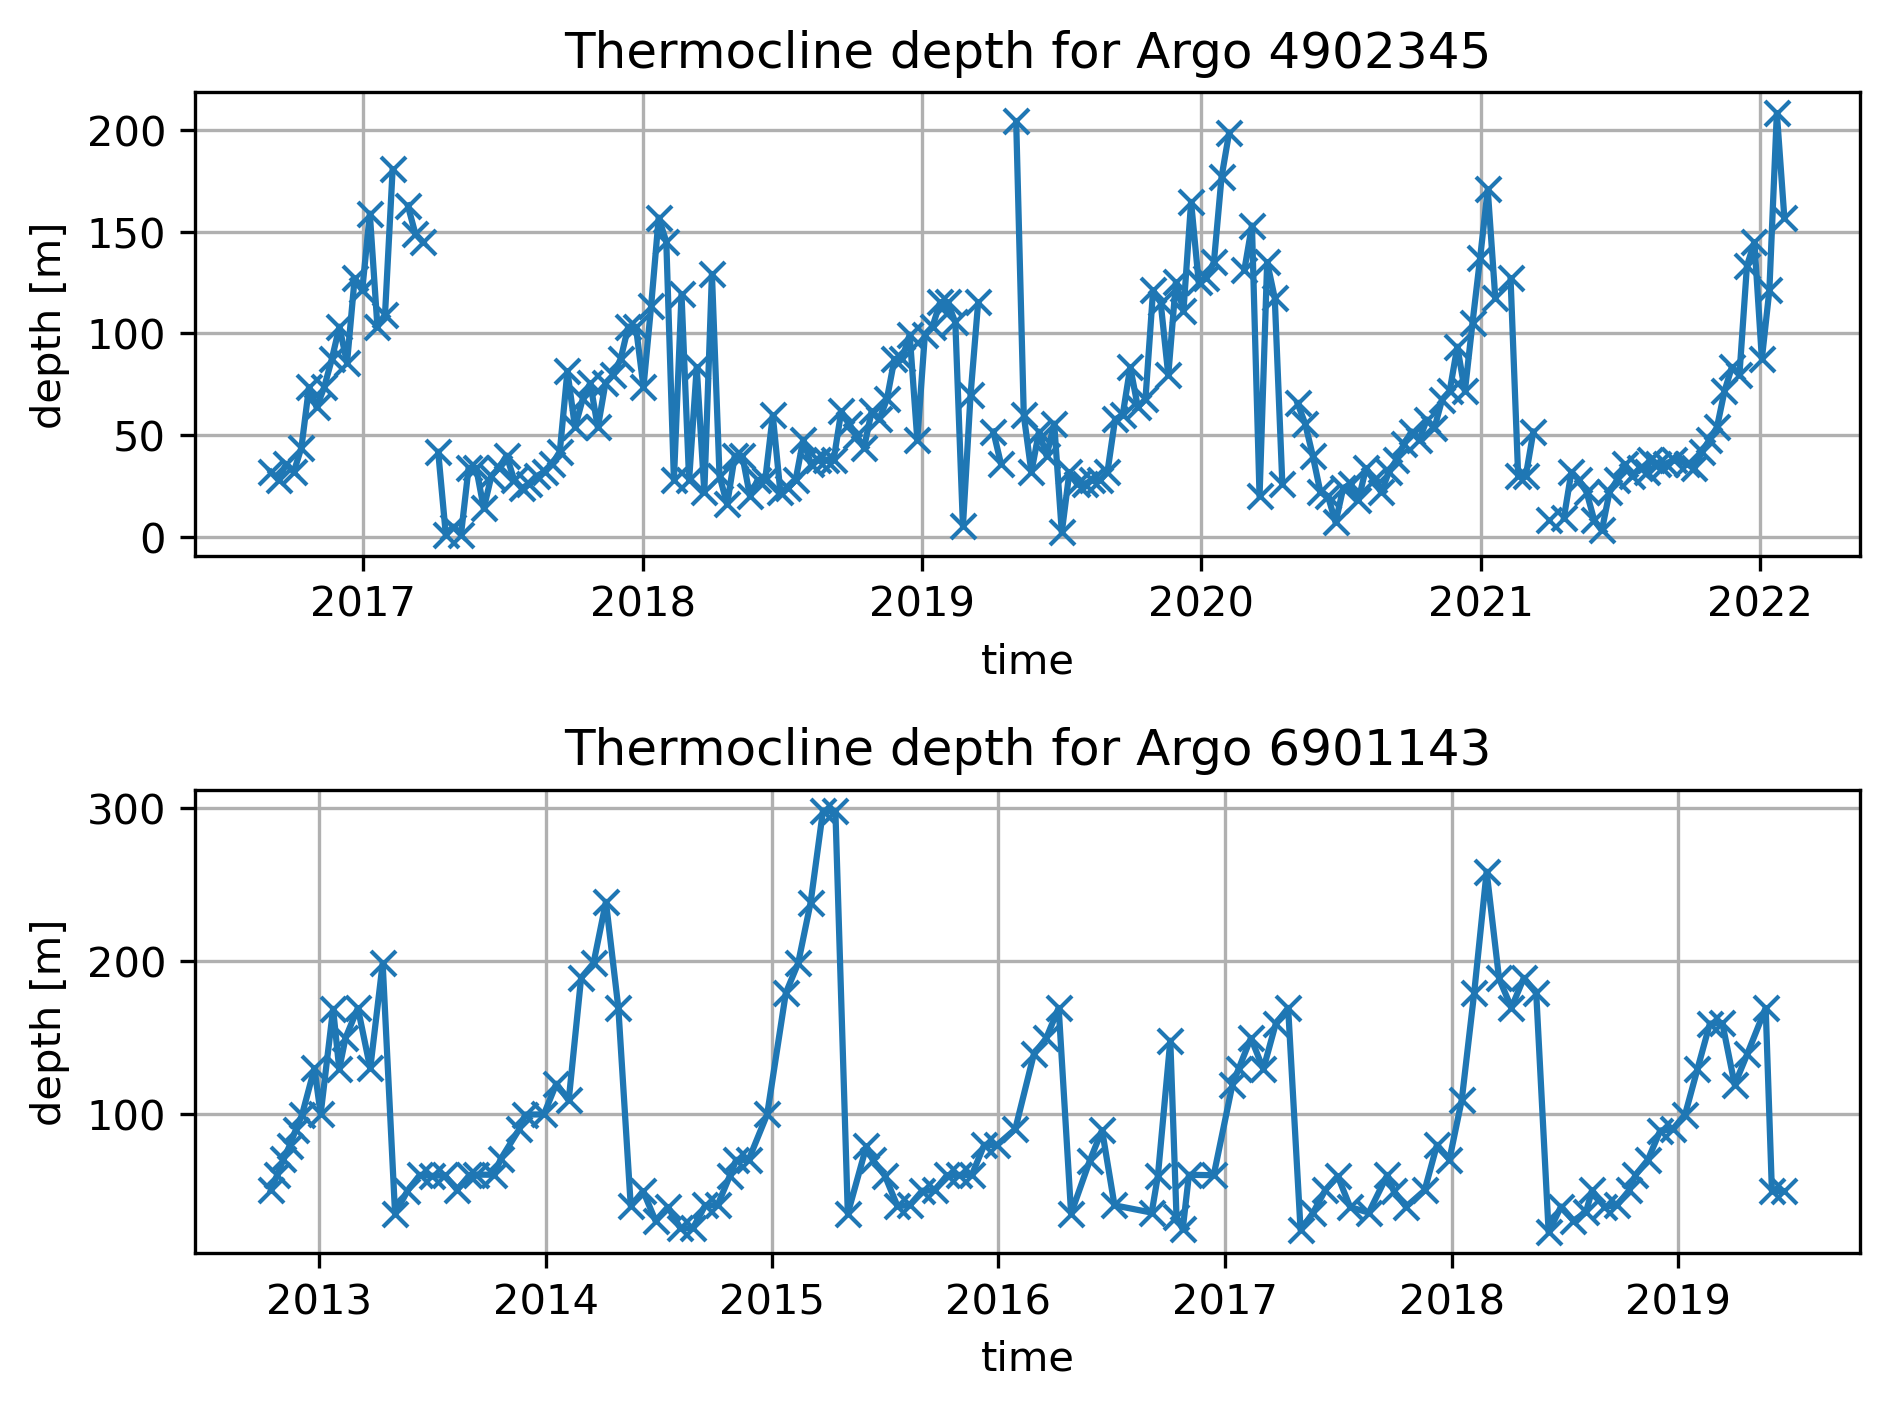

In [36]:
fig,axs = plt.subplots(2,1,dpi = 300)
axs[0].plot(df_aoml_tc["date"],df_aoml_tc["tc_depth"],marker = "x")
axs[0].set_title(f"Thermocline depth for Argo {4902345}")
axs[0].set_ylabel("depth [m]")
axs[0].set_xlabel("time")
axs[0].grid()

axs[1].plot(df_bodc_tc["date"],df_bodc_tc["tc_depth"],marker = "x")
axs[1].set_title(f"Thermocline depth for Argo {6901143}")
axs[1].set_ylabel("depth [m]")
axs[1].set_xlabel("time")
axs[1].grid()

fig.tight_layout()